<a href="https://colab.research.google.com/github/DineshChopra/AI-ML/blob/master/TensorFlow/Udacity/6_TransferLearning_Identify_Reflection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Follow URL:
https://medium.com/analytics-vidhya/create-tensorflow-image-classification-model-with-your-own-dataset-in-google-colab-63e9d7853a3e

In [1]:
from google.colab import drive

In [2]:
drive.mount('Assignments')

Mounted at Assignments


In [3]:
ls

Assignments/  sample_data/


In [4]:
ls Assignments/

MyDrive/  Shareddrives/


In [5]:
cd Assignments/MyDrive/Assignments

/content/Assignments/MyDrive/Assignments


In [6]:
ls Data_with_Reflection

Test/  Train/


In [7]:
import tensorflow as tf

import matplotlib.pylab as plt

import tensorflow_hub as hub

import tensorflow_datasets as tfds

from tensorflow.keras import layers
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np

In [9]:
!pip install -U -q PyDrive
from pydrive.drive import GoogleDrive

In [14]:
train_data_root = '/content/Assignments/MyDrive/Assignments/Data_with_Reflection/Train'
test_data_root = '/content/Assignments/MyDrive/Assignments/Data_with_Reflection/Test'

In [32]:
IMAGE_RES = 224
IMAGE_SHAPE = (IMAGE_RES, IMAGE_RES)
TRAINING_DATA_DIR = str(train_data_root)
TEST_DATA_DIR = str(test_data_root)
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
print(TRAINING_DATA_DIR)

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)

valid_generator = valid_datagen.flow_from_directory(
  TRAINING_DATA_DIR,
  subset="validation",
  shuffle=True,
  target_size=IMAGE_SHAPE
)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)

train_generator = train_datagen.flow_from_directory(
  TRAINING_DATA_DIR,
  subset="training",
  shuffle=True,
  target_size=IMAGE_SHAPE
)
print(train_generator)


/content/Assignments/MyDrive/Assignments/Data_with_Reflection/Train
Found 12 images belonging to 2 classes.
Found 56 images belonging to 2 classes.


In [17]:
image_batch_train, label_batch_train = next(iter(train_generator))
print("Image batch shape: ", image_batch_train.shape)
print("Label batch shape: ", label_batch_train.shape)
dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

Image batch shape:  (24, 224, 224, 3)
Label batch shape:  (24, 2)
['With_Reflection' 'Without_Reflection']


## Get Model from TensorFlow Hub

In [33]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
IMAGE_RES = 224
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES,3),
                                   output_shape=[1280],
                                   trainable=False)

In [18]:
model = tf.keras.Sequential([
hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",
output_shape=[1280],
trainable=False),
tf.keras.layers.Dropout(0.4),
tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])
model.build([None, 224, 224, 3])
model.summary()
model.compile(
optimizer=tf.keras.optimizers.Adam(),
loss='categorical_crossentropy',
metrics=['acc'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [20]:
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)
hist = model.fit(
  train_generator,
  epochs=40,
  verbose=1,
  steps_per_epoch=steps_per_epoch,
  validation_data=valid_generator,
  validation_steps=val_steps_per_epoch
).history

Epoch 1/40
2/2 [==============================] - 0s 290ms/step - loss: 0.4119 - acc: 0.8393 - val_loss: 0.4632 - val_acc: 0.8333
Epoch 2/40
2/2 [==============================] - 0s 210ms/step - loss: 0.4279 - acc: 0.8393 - val_loss: 0.4489 - val_acc: 0.8333
Epoch 3/40
2/2 [==============================] - 1s 397ms/step - loss: 0.3526 - acc: 0.8929 - val_loss: 0.4316 - val_acc: 0.8333
Epoch 4/40
2/2 [==============================] - 0s 263ms/step - loss: 0.3448 - acc: 0.8750 - val_loss: 0.4158 - val_acc: 0.8333
Epoch 5/40
2/2 [==============================] - 0s 260ms/step - loss: 0.3004 - acc: 0.9107 - val_loss: 0.3940 - val_acc: 0.8333
Epoch 6/40
2/2 [==============================] - 0s 256ms/step - loss: 0.3519 - acc: 0.8571 - val_loss: 0.3755 - val_acc: 0.8333
Epoch 7/40
2/2 [==============================] - 0s 267ms/step - loss: 0.2860 - acc: 0.8929 - val_loss: 0.3622 - val_acc: 0.8333
Epoch 8/40
2/2 [==============================] - 0s 262ms/step - loss: 0.2989 - acc: 0.85

## Validation

In [21]:
val_image_batch, val_label_batch = next(iter(valid_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)
print("Validation batch shape:", val_image_batch.shape)

Validation batch shape: (12, 224, 224, 3)


## Testing our Model

In [24]:
import pandas as pd

In [25]:
tf_model_predictions = model.predict(val_image_batch)
tf_pred_dataframe = pd.DataFrame(tf_model_predictions)
tf_pred_dataframe.columns = dataset_labels
print("Prediction results for the first elements")
tf_pred_dataframe.head()

Prediction results for the first elements


,With_Reflection,Without_Reflection
0,0.966643,0.033357
1,0.703166,0.296834
2,0.084627,0.915373
3,0.149069,0.850931
4,0.033700,0.966300


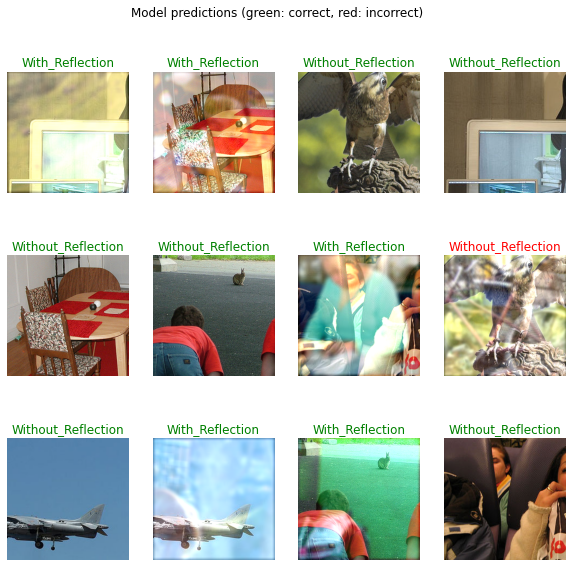

In [31]:
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(12):
  plt.subplot(3,4,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')

_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")